<h1 align="center">GNNs - Master in Deep Learning of UPM</h1>

Deberéis descomentar esta celda si no disponéis del setup necesario para trabajar con Pytorch Geometric o si estáis en Colab :).

In [7]:
# %%capture
# import torch

# def format_pytorch_version(version):
#   return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)

# def format_cuda_version(version):
#   return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install pyg-lib           -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric 

In [8]:
import os
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import NeighborLoader, ClusterData, ClusterLoader, GraphSAINTRandomWalkSampler, GraphSAINTNodeSampler, GraphSAINTEdgeSampler
from torch_geometric.datasets import CitationFull, TUDataset
from torch_geometric.nn import GIN, GCN, MLP, GAT, global_mean_pool

# Ejercicio propuesto: Clasificación a nivel de nodo

Utilizaremos el dataset CiteSeer. Los nodos representan documentos y las aristas citaciones.

In [9]:
from torch_geometric.datasets.planetoid import Planetoid

dataset = Planetoid(root='CiteSeer', name='CiteSeer', 
                    split='random', num_train_per_class=350, num_val=500, num_test=500)
data = dataset[0] # Cogemos el primer y único grafo del dataset

print(f"Nodos: {dataset[0].num_nodes}")
print(f"Aristas: {dataset[0].num_edges}")
print(f"Características: {dataset.num_features}")
print(f"Clases: {dataset.num_classes}")

Nodos: 3327
Aristas: 9104
Características: 3703
Clases: 6


Este dataset ya viene separado en train, validation y test.

In [10]:
print(f"Train mask: {data.train_mask.sum()}")
print(f"Val mask: {data.val_mask.sum()}")
print(f"Test mask: {data.test_mask.sum()}")

Train mask: 2014
Val mask: 500
Test mask: 500


----
El objetivo de este ejercicio será la creación de un entorno de experimentación que nos permita comparar diferentes arquitecturas, métodos de sampleo y diferentes hiperparámetros.

Para la comparación tendremos en cuenta 3 arquitecturas de GNNs como son:

- GIN
- GCN
- GAT

Las arquitecturas que generemos deberán tener como _encoder_ estas arquitecturas y deberán estar enfocadas a la tarea de clasificación a nivel de nodo.

La clase NodeClassifier implementará un `Module` de PyTorch Geometric y recibirá en el `__init__`:
1. `encoder` *: Siendo un `str` entre tres valores:
    - 'GIN': el encoder del clasificador será un modelo GIN.
    - 'GCN': el encoder del clasificador será un modelo GCN.
    - 'GAT': el encoder del clasificador será un modelo GAT.
2. `num_features` *: El número de características de los nodos del grafo.
3. `num_classes` *: El número de clases que puede tener un nodo. 
4. `hidden_channels`:  La dimensión oculta del modelo, por defecto 32.
5. `num_layers`: El número de capas (paso de mensajes) del encoder, por defecto 2.
6. `dropout`: Un `float` que denote el dropout que se use en el encoder, por defecto 0.5.
7. `act`: Un `str` que especifique la función de activación, por defecto 'relu'.
8. `jk`: El jumping knowledge que se aplicará a la salida de la GNN, por defecto 'cat'.

El diseño y parametrización de la cabeza de clasificación queda a elección del alumno, como recomendación (ya que no va a variar mucho los resultados) se puede dejar constante.

La función `forward` deberá recibir los siguientes parámetros:
- `self` *: ya que es una función de una clase python.
- `x` *: las features de los nodos.
- `edge_index` *: las aristas de los nodos.
- `edge_weights`: opcionalmente pesos para las aristas, por defecto None.

In [11]:
class NodeClassifier(Module):
    def __init__(self,
            encoder,
            num_features,
            num_classes,
            hidden_channels = 32,
            num_layers = 2,
            dropout = 0.5,
            act = "relu",
            jk = "cat"
        ):
        super(NodeClassifier, self).__init__()
        str2cls = {
            "GCN": GCN,
            "GIN": GIN,
            "GAT": GAT
        }
        
        self.encoder = str2cls[encoder](
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            out_channels=hidden_channels,
            dropout=dropout,
            act=act,
            jk=jk
        )

        self.head = MLP(
            in_channels=hidden_channels, 
            hidden_channels=hidden_channels,
            out_channels=num_classes, 
            num_layers=2,
            dropout=0.5
        )
    
    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.head.reset_parameters()

    def forward(self, x, edge_index, edge_weight=None):
        x = self.encoder(x, edge_index, edge_weight)
        x = self.head(x)
        return x

Probemos si se instancia bien realizando una inferencia con números random.

In [12]:
encoder = "GCN"
num_features = dataset.num_features
num_classes = dataset.num_classes

x = torch.rand((data.num_nodes, num_features))
edge_index = data.edge_index
edge_weight = None

classifier = NodeClassifier(encoder, num_features, num_classes)

out = classifier(x, edge_index, edge_weight=edge_weight)

print(f"X shape: {x.shape}")
print(f"Edge shape: {edge_index.shape}")
print(f"Output shape: {out.shape}")

X shape: torch.Size([3327, 3703])
Edge shape: torch.Size([2, 9104])
Output shape: torch.Size([3327, 6])


-----
A continuación vamos a crear una clase `NodeDataModule` que nos generará el dataloader en función de los siguientes parámetros:

1. `data` *: el grafo.

2. `sampling` *: que será un str entre los siguientes valores: 
    - 'graph_sage': instanciará el `NeighborLoader`.
    - 'graph_saint_node': instanciará el `GraphSAINTNodeSampler`.
    - 'graph_saint_edge': instanciará el `GraphSAINTEdgeSampler`.
    - 'graph_saint_rw': instanciará el `GraphSAINTRandomWalkSampler`.

3. `batch_size` *: el tamaño de cada sub-grafo.

4. `**kwargs`: que será el resto de parámetros que necesite cada método en particular. 

Deberá en el propio `__init__` almacenar:

1. `self.data`: el dataset.
2. `self.sampling`: el método de sampling.
3. `self.dataloader`: el dataloader.

In [13]:
class NodeDataModule:
    def __init__(self, data, sampling, batch_size, **kwargs):
        self.data = data
        self.sampling = sampling

        if sampling == "graph_sage":
            self.dataloader = NeighborLoader(data, batch_size=batch_size, shuffle=True, **kwargs)
        elif sampling == "graph_saint_node":
            self.dataloader = GraphSAINTNodeSampler(data, batch_size=batch_size, shuffle=True, **kwargs)
        elif sampling == "graph_saint_edge":
            self.dataloader = GraphSAINTEdgeSampler(data, batch_size=batch_size, shuffle=True, **kwargs)
        elif sampling == "graph_saint_rw":
            self.dataloader = GraphSAINTRandomWalkSampler(data, batch_size=batch_size, shuffle=True, **kwargs)
        else:
            raise ValueError(f"Sampling method {sampling} not implemented")

Probemos si funciona

In [14]:
graph_sage_loader = NodeDataModule(data, "graph_sage", batch_size=32, num_neighbors=[10, 10]).dataloader
graph_saint_node_loader = NodeDataModule(data, "graph_saint_node", batch_size=32, sample_coverage=10).dataloader
graph_saint_edge_loader = NodeDataModule(data, "graph_saint_edge", batch_size=32, sample_coverage=10).dataloader
graph_saint_random_walk_loader = NodeDataModule(data, "graph_saint_rw", batch_size=32, sample_coverage=100, num_steps=5, walk_length=3).dataloader

print(f'Primer batch GraphSAGE')
for batch in graph_sage_loader:
    print(f"X shape: {batch.x.shape}")
    print(f"Edge shape: {batch.edge_index.shape}")
    print(f"Output shape: {classifier(batch.x, batch.edge_index).shape}")
    break
print('-----------------------------------')

print(f'Primer batch GraphSAINT Node')
for batch in graph_saint_node_loader:
    print(f"X shape: {batch.x.shape}")
    print(f"Edge shape: {batch.edge_index.shape}")
    print(f"Output shape: {classifier(batch.x, batch.edge_index).shape}")
    break
print('-----------------------------------')

print(f'Primer batch GraphSAINT Edge')
for batch in graph_saint_edge_loader:
    print(f"X shape: {batch.x.shape}")
    print(f"Edge shape: {batch.edge_index.shape}")
    print(f"Output shape: {classifier(batch.x, batch.edge_index).shape}")
    break
print('-----------------------------------')

print(f'Primer batch GraphSAINT Random Walk')
for batch in graph_saint_random_walk_loader:
    print(f"X shape: {batch.x.shape}")
    print(f"Edge shape: {batch.edge_index.shape}")
    print(f"Output shape: {classifier(batch.x, batch.edge_index).shape}")
    break
print('-----------------------------------')

Compute GraphSAINT normalization: : 33290it [00:00, 148158.93it/s]                         
Compute GraphSAINT normalization: : 33321it [00:01, 17730.89it/s]                         
Compute GraphSAINT normalization: : 333043it [00:00, 553753.48it/s]                          


Primer batch GraphSAGE
X shape: torch.Size([280, 3703])
Edge shape: torch.Size([2, 451])
Output shape: torch.Size([280, 6])
-----------------------------------
Primer batch GraphSAINT Node
X shape: torch.Size([32, 3703])
Edge shape: torch.Size([2, 0])
Output shape: torch.Size([32, 6])
-----------------------------------
Primer batch GraphSAINT Edge
X shape: torch.Size([57, 3703])
Edge shape: torch.Size([2, 116])
Output shape: torch.Size([57, 6])
-----------------------------------
Primer batch GraphSAINT Random Walk
X shape: torch.Size([98, 3703])
Edge shape: torch.Size([2, 172])
Output shape: torch.Size([98, 6])
-----------------------------------


Finalmente, vamos a crear la clase Trainer siguiendo un estilo similar al de PytorchLightning para el LightningModule. Los métodos a completar son los siguientes:

1. `graph_sage_step`: deberá procesar un batch y computar la loss para ese mismo batch.
2. `graph_saint_step`: deberá procesar un batch teniendo en cuenta los pesos que graph saint nos otorga y devolver la loss para ese mismo batch.
3. `train`: se deberá gestionar que función de step utilizar dependiendo del método de sampling elegido.

In [15]:
class Trainer:
    def __init__(self, module, datamodule):
        self.module = module
        self.datamodule = datamodule

    def graph_sage_step(self, batch):
        out = self.module(batch.x, batch.edge_index)
        loss = self.criterion(out[batch.train_mask], batch.y[batch.train_mask])
        return loss
    
    def graph_saint_step(self, batch):
        out = self.module(batch.x, batch.edge_index, edge_weight=batch.edge_norm)

        out = out.log_softmax(dim=-1)
        
        loss = F.nll_loss(out, batch.y, reduction='none')
        loss = (loss * batch.node_norm)[batch.train_mask].sum()

        return loss

    def validate(self):
        self.module.eval()
        data = self.datamodule.data
        out = self.module(data.x, data.edge_index)
        loss = CrossEntropyLoss()(out[data.val_mask], data.y[data.val_mask])
        return loss.item()
    
    def test(self):
        self.module.eval()
        data = self.datamodule.data
        out = self.module(data.x, data.edge_index)
        y_pred = out.argmax(dim=1)[data.test_mask].tolist()
        y_true = data.y[data.test_mask].tolist()
        f1 = f1_score(y_true, y_pred, average='macro')
        print(f"Test F1 Score: {f1}")
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', cmap='Blues')
        return f1

    def train(self, optimizer, criterion, device, epochs=100, val_every=5):
        self.module.train()

        self.criterion = criterion

        if self.datamodule.sampling == 'graph_sage':
            self.step_fn = self.graph_sage_step
        elif self.datamodule.sampling.startswith('graph_saint'):
            self.step_fn = self.graph_saint_step

        for epoch in range(epochs):
            epoch_loss = 0
            for batch in self.datamodule.dataloader:
                batch = batch.to(device)

                optimizer.zero_grad()

                loss = self.step_fn(batch)

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
            
            loss = epoch_loss/len(self.datamodule.dataloader)
            
            if epoch % val_every == 0:
                val_loss = self.validate()
                print(f"Epoch {epoch}: Loss {loss}, Val Loss {val_loss}")

        return self.module

Esta función nos permitirá guardar como una cadena de texto los hiperparámetros del último experimento realizado. Por defecto se guardará con el f1 obtenido en el conjunto de test.

In [16]:
def save_exp_as_string(hp, test_f1):
    exp_dir = f"experiments/{test_f1:.5f}.txt"
    os.makedirs(os.path.dirname(exp_dir), exist_ok=True)  # Asegura que la carpeta exista
    hp_string = str(hp)  # Convierte el diccionario a string
    with open(exp_dir, 'w') as f:  # Guarda como texto
        f.write(hp_string)

------
A experimentar!!!

Epoch 0: Loss 1.0935081197665288, Val Loss 1.331979513168335
Epoch 5: Loss 0.11410036457415956, Val Loss 1.5454615354537964
Test F1 Score: 0.5992958055227934


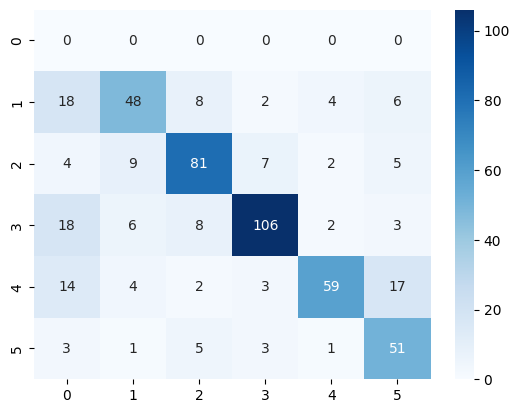

In [17]:
hp = {
    'module_hp': {
        'encoder': 'GIN',
        'num_features': dataset.num_features,
        'num_classes': dataset.num_classes,
        'hidden_channels': 32,
        'num_layers': 2,
        'dropout': 0.5,
        'act': 'relu',
        'jk': 'cat'
    },
    'dataloader_hp': {
        'sampling': 'graph_sage',
        'batch_size': 32,
        'kwargs': {
            'num_neighbors': [10, 10]
        }
        # 'kwargs': {
        #     'num_neighbors': [10, 10]
        # }
        # 'kwargs': {
        #     'sample_coverage': 100, 
        #     'num_steps': 5, 
        #     'walk_length': 3
        # }
    },
    'trainer_hp': {
        'optimizer': {
            'cls' : Adam,
            'lr': 0.01,
            'weight_decay': 5e-4
        },
        'criterion': CrossEntropyLoss,
        'epochs': 10,
        'val_every': 5,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }
}

module = NodeClassifier(
    hp['module_hp']['encoder'],
    hp['module_hp']['num_features'],
    hp['module_hp']['num_classes'],
    hp['module_hp']['hidden_channels'],
    hp['module_hp']['num_layers'],
    hp['module_hp']['dropout'],
    hp['module_hp']['act'],
    hp['module_hp']['jk']
)

datamodule = NodeDataModule(
    data,
    hp['dataloader_hp']['sampling'],
    hp['dataloader_hp']['batch_size'],
    **hp['dataloader_hp']['kwargs']
)

optimizer_cls = hp['trainer_hp']['optimizer']['cls']
lr = hp['trainer_hp']['optimizer']['lr']
weight_decay = hp['trainer_hp']['optimizer']['weight_decay']

optimizer = optimizer_cls(module.parameters(), lr=lr, weight_decay=weight_decay)
criterion = hp['trainer_hp']['criterion']()
device = hp['trainer_hp']['device']
epochs = hp['trainer_hp']['epochs']
val_every = hp['trainer_hp']['val_every']

trainer = Trainer(module, datamodule)

module = trainer.train(optimizer, criterion, device, epochs=epochs, val_every=val_every)
test_f1 = trainer.test()

In [18]:
save_exp_as_string(hp, test_f1)

-----